Installing All the Necessary Packages

In [3]:
!pip install transformers datasets
!pip install bitsandbytes
!pip install evaluate
!pip install trl
!pip install -U huggingface_hub

  Using cached bitsandbytes-0.45.3-py3-none-manylinux_2_24_x86_64.whl.metadata (5.0 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached bitsandbytes-0.45.3-py3-none-manylinux_2_24_x86_64.whl (76.1 MB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manyli

Loading the Dataset

In [ ]:
from datasets import load_dataset
import random
from datasets import Dataset, DatasetDict

# Load the OPUS books dataset
dataset = load_dataset("opus100", "de-fr")

# Extract all data
all_data = dataset["test"]

# Shuffle and select 1100 random pairs
random.seed(42)  # For reproducibility
selected_data = all_data.shuffle(seed=42).select(range(1100))

# Function to remove duplicates and keep only unique pairs
def remove_duplicates(dataset):
    unique_german_sentences = set()
    unique_data = []

    for example in dataset:
        german_sentence = example["translation"]["de"]
        if german_sentence not in unique_german_sentences:
            unique_german_sentences.add(german_sentence)
            unique_data.append(example)

    # Convert the unique pairs back to a Dataset
    unique_data = Dataset.from_list(unique_data)
    return unique_data

# Remove duplicates from the selected data
unique_data = remove_duplicates(selected_data)

# Check if we have enough unique pairs
if len(unique_data) < 1000:
    raise ValueError(f"Not enough unique pairs in the dataset. Found {len(unique_data)} unique pairs, but need at least 1000.")

# Shuffle the unique data again to ensure randomness
unique_data = unique_data.shuffle(seed=42)

# Split into train (800 pairs) and test (200 pairs)
train_data = unique_data.select(range(800))
test_data = unique_data.select(range(800, 1000))

# Create DatasetDict
split_dataset = DatasetDict({
    "train": train_data,
    "test": test_data
})

# Save the train data to a JSON file
train_data.to_json("train_data_A.json")
test_data.to_json("test_data_A.json")

print("Train data saved to 'Dataset_A.json'.")

# ... (Rest of your code remains the same)`
def check_duplicates_and_unique_pairs(dataset):
    # Create a dictionary to store pairs and their counts
    pair_counts = {}

    # Iterate through the dataset
    for example in dataset:
        pair = (example["translation"]["de"], example["translation"]["fr"])
        if pair in pair_counts:
            pair_counts[pair] += 1
        else:
            pair_counts[pair] = 1

    # Count duplicates and unique pairs
    duplicates = {pair: count for pair, count in pair_counts.items() if count > 1}
    unique_pairs = {pair: count for pair, count in pair_counts.items() if count == 1}

    # Print results
    print(f"Total pairs: {len(pair_counts)}")
    print(f"Unique pairs: {len(unique_pairs)}")
    print(f"Duplicate pairs: {len(duplicates)}")
    if duplicates:
        print("Duplicate pairs and their counts:")
        for pair, count in duplicates.items():
            print(f"Source: {pair[0]}, Target: {pair[1]}, Count: {count}")
    else:
        print("No duplicate pairs found.")

# Check duplicates and unique pairs in the train dataset
print("\nChecking duplicates and unique pairs in the train dataset:")
check_duplicates_and_unique_pairs(train_data)

# Check duplicates and unique pairs in the test dataset
print("\nChecking duplicates and unique pairs in the test dataset:")
check_duplicates_and_unique_pairs(test_data)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Train data saved to 'Dataset_A.json'.

Checking duplicates and unique pairs in the train dataset:
Total pairs: 800
Unique pairs: 800
Duplicate pairs: 0
No duplicate pairs found.

Checking duplicates and unique pairs in the test dataset:
Total pairs: 200
Unique pairs: 200
Duplicate pairs: 0
No duplicate pairs found.


Loading the Pre-trained Model

In [ ]:
from transformers import BitsAndBytesConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Set up the quantization configuration
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Pass the quantization configuration when loading the model
from transformers import AutoModelForCausalLM

# Load the quantized model
model_a = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B",
                                             quantization_config=quant_config)

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

# # Set padding token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Printing the Model

In [ ]:
print(model_a)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear4bit(in_features=2048, out_features=8192, bias=True)

In [ ]:
# Function to generate translations
def generate_translation(model, tokenizer, input_text):
    inputs = tokenizer(input_text, return_tensors="pt", max_length=256, truncation=True).to("cuda")
    outputs = model.generate(inputs["input_ids"], max_new_tokens=100, pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
from evaluate import load

# Load the BLEU metric
bleu = load("bleu")

In [ ]:
def extract_french_text(full_output):
    # Extract all French sentences
    french_sentences = []
    lines = full_output.split("\n")
    for line in lines:
        if line.strip().startswith("French:"):
            french_part = line.split("French:")[1].strip()
            french_sentences.append(french_part)

    # Join all extracted French sentences
    french_translation = " ".join(french_sentences)

    return french_translation

Evaluating the Pre-trained Model

In [ ]:
# Evaluate Model A on the test dataset
predictions = []
references = []

for example in test_data:
    source_text = example["translation"]["de"]
    target_text = example["translation"]["fr"]

    # Generate translation
    predicted_text = generate_translation(model_a, tokenizer, f"Accuratly Translate German to French:\nGerman: {source_text}")
    predictions.append(predicted_text)
    references.append([target_text])  # BLEU expects a list of references
    french_translation_a = [extract_french_text(output) for output in predictions]

# Compute BLEU score
bleu_score_a = bleu.compute(predictions=french_translation_a, references=references)
print(f"BLEU Score (Pre-trained Model): {bleu_score_a['bleu']}")

BLEU Score (Pre-trained Model): 0.025975858641472567


Setting up LoRA configuration for fine-tuning

In [ ]:
# Import necessary PEFT objects for preparing the model for LoRA training
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from trl import SFTConfig
from trl import SFTTrainer

# Prepare the model for LoRA, which includes float conversions to help stabilize training
model = prepare_model_for_kbit_training(model_a)

# Set up LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=64,
    target_modules=["k_proj", "v_proj", "q_proj", "out_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Get the model with unfrozen LoRA layers applied
model = get_peft_model(model, lora_config)

Fine-Tuning Model A on Train Dataset A

In [ ]:
# Get the model with unfrozen LoRA layers applied
model = get_peft_model(model, lora_config)

# Set up the training hyperparameters
training_arguments = SFTConfig(
    fp16=True,
    dataset_text_field="text",
    max_seq_length=256,
    per_device_train_batch_size=4,

    # Optimizer-related parameters
    optim="paged_adamw_32bit",
    learning_rate=1e-4,
 and
    # Epochs and saving configuration
    num_train_epochs=2,
    save_strategy="epoch",
    output_dir="./epoch-finetuned",

    # Validation-related parameters
    eval_strategy="no",
    eval_steps=0.2,

    # Logging-related parameters
    report_to="none",
    logging_dir="./logs",
    logging_steps=50,
    seed=42,
)

# Enable gradient checkpointing to save memory and recompute during backpropagation
model.gradient_checkpointing_enable()

# Disable attention cache during training; it should be enabled during inference
model.config.use_cache = False

# # Preprocess the train dataset
def format_translation_prompt(source, target):
    return f"Translate German to French:\nGerman: {source}\nFrench: {target}"

def preprocess_dataset(data):
    return data.map(lambda x: {"text": format_translation_prompt(x["translation"]["de"], x["translation"]["fr"])})

train_data = preprocess_dataset(train_data)

trainer = SFTTrainer(

    model=model,
    tokenizer=tokenizer,
    train_dataset=train_data,
    peft_config=lora_config,
    args=training_arguments,
)

# Start training
trainer.train()

# Define the save path for the fine-tuned model on Colab
peft_model_path = "./fine-tuned-gpt-neo"

# Save the trained model
trainer.model.save_pretrained(peft_model_path)

# Save the tokenizer
tokenizer.save_pretrained(peft_model_path)

# List the saved files
!ls -lh {peft_model_path}

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

<ipython-input-15-683f496a08d5>:45: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Converting train dataset to ChatML:   0%|          | 0/800 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Step,Training Loss
50,1.954600
100,1.842600
150,1.792500
200,1.818000
250,1.700300
300,1.710700
350,1.760400
400,1.732600


total 29M
-rw-r--r-- 1 root root  749 Mar 13 18:10 adapter_config.json
-rw-r--r-- 1 root root  25M Mar 13 18:10 adapter_model.safetensors
-rw-r--r-- 1 root root 446K Mar 13 18:10 merges.txt
-rw-r--r-- 1 root root 5.0K Mar 13 18:10 README.md
-rw-r--r-- 1 root root  470 Mar 13 18:10 special_tokens_map.json
-rw-r--r-- 1 root root  556 Mar 13 18:10 tokenizer_config.json
-rw-r--r-- 1 root root 3.4M Mar 13 18:10 tokenizer.json
-rw-r--r-- 1 root root 780K Mar 13 18:10 vocab.json


Evaluating Model B on Test Dataset A

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

# Load the fine-tuned model
peft_model_path = "./fine-tuned-gpt-neo"
tuned_model_b = AutoPeftModelForCausalLM.from_pretrained(peft_model_path).to("cuda")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)

# Set the padding token to be the same as the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token

# Specify that padding should be added to the right side of the sequences
tokenizer.padding_side = "right"

# Enable attention cache during inference
tuned_model_b.config.use_cache = True


def generate_french_translation(model, tokenizer, input_text):
    # Generate the translation
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to("cuda")
    outputs = model.generate(inputs["input_ids"], max_new_tokens=100, pad_token_id=tokenizer.eos_token_id)
    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)


    return full_output

In [ ]:
# Evaluate on the test dataset
full_output_b = []
french_translation_b = []
references_b = []

for example in test_data:
    source_text = example["translation"]["de"]
    target_text = example["translation"]["fr"]

    # Generate translation and extract only the French part
    full_output = generate_french_translation(tuned_model_b, tokenizer, f"Translate German to French:\nGerman: {source_text}")
    full_output_b.append(full_output)
    references_b.append([target_text])

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [ ]:
french_translation_b = [extract_french_text(output) for output in full_output_b]

['3.2 Quels aspects concrets sont concernés par le rapport présenté, d.h. ce que devrait-il faire? 3.2 Quels aspects concrets sont concernés par le rapport présenté, d.h. ce que devrait-il faire?', 'Je veux vous rappeler que dans le métier de chauffeur, on appelle le benchmarking. Je veux vous rappeler que dans le métier de chauffeur, on appelle le benchmarking.', "Le fonds national de solidarité (FNS) est créé par le traité de Maastricht, qui a été ratifié par le Conseil de l'Union européenne. Le FNS est créé par le traité de Maastricht, qui a été ratifié par le Conseil de l'Union européenne. Le FNS est", "Qu'est-ce que tu fais si bien ? Qu'est-ce que tu fais si bien ? Qu'est-ce que tu fais si bien ? Qu'est-ce que tu fais si", 'Vous avez la numéro du vendeur ? Vous avez la numéro du vendeur ? Vous avez la numéro du vendeur ? Vous avez la numéro du vendeur ?', "Il semble que l'un des hommes qui se trouve dans ce navire ait été blessé. Il semble que l'un des hommes qui se trouve d", '- 

In [ ]:
# Compute BLEU score for Model B
bleu_score_model_b = bleu.compute(predictions=french_translation_b, references=references_b)
print(f"BLEU Score (Model B): {bleu_score_model_b['bleu']}")

BLEU Score (Fine-tuned Model): 0.036279791189212894


Generating Synthetic Dataset B

In [ ]:
from huggingface_hub import InferenceClient
import json

# Initialize the InferenceClient
client = InferenceClient(
    provider="fireworks-ai",
    api_key=""
)
# Function to generate a batch of unique sentence pairs
def generate_batch(num_pairs, existing_pairs):
    prompt = f"""
    You are a professional translator. Your task is to translate German sentences into French.
    Generate {num_pairs} German-to-French sentence pairs. Each pair should consist of a German sentence followed by its French translation.
    The sentences should cover a wide range of topics, including everyday conversations, travel, business, and technology.
    Ensure that the translations are accurate and natural-sounding.

    Example:
    German: Guten Morgen!
    French: Bonjour!

    German: Wie geht es Ihnen?
    French: Comment allez-vous?

    Now, generate {num_pairs} such pairs:
    """

    messages = [
        {
            "role": "user",
            "content": prompt
        }
    ]

    completion = client.chat.completions.create(
        model="Qwen/Qwen2.5-Coder-32B-Instruct",
        messages=messages,
        max_tokens=4000,
        temperature=0.7,
    )

    # Extract the generated text
    generated_text = completion.choices[0].message.content

    # Process the generated text into a structured dataset
    pairs = generated_text.strip().split("\n\n")

    dataset_batch = []
    for pair in pairs:
        if "German:" in pair and "French:" in pair:
            german_sentence = pair.split("German:")[1].split("French:")[0].strip()
            french_sentence = pair.split("French:")[1].strip()
            pair_tuple = (german_sentence, french_sentence)

            # Check if the pair is unique
            if pair_tuple not in existing_pairs:
                dataset_batch.append({
                    "german": german_sentence,
                    "french": french_sentence
                })
                existing_pairs.add(pair_tuple)

    return dataset_batch

# Generate the full dataset with exactly 1600 unique pairs
dataset_b = []
existing_pairs = set()
batch_size = 100
total_batches = 16

for i in range(total_batches):
    print(f"Generating batch {i + 1} of {total_batches}...")
    batch = generate_batch(batch_size, existing_pairs)
    dataset_b.extend(batch)
    print(f"Total pairs generated: {len(dataset_b)}")

    # Stop if we have reached the required number of pairs
    if len(dataset_b) >= 1600:
        dataset_b = dataset_b[:1600]
        break

# Save the dataset to a JSON file
with open("dataset_b.json", "w", encoding="utf-8") as f:
    json.dump(dataset_b, f, ensure_ascii=False, indent=4)

print(f"Generated {len(dataset_b)} unique German-to-French sentence pairs and saved to 'dataset_b.json'.")

Generating batch 1 of 16...
Total pairs generated: 74
Generating batch 2 of 16...
Total pairs generated: 161
Generating batch 3 of 16...
Total pairs generated: 220
Generating batch 4 of 16...
Total pairs generated: 300
Generating batch 5 of 16...
Total pairs generated: 351
Generating batch 6 of 16...
Total pairs generated: 410
Generating batch 7 of 16...
Total pairs generated: 479
Generating batch 8 of 16...
Total pairs generated: 535
Generating batch 9 of 16...
Total pairs generated: 602
Generating batch 10 of 16...
Total pairs generated: 602
Generating batch 11 of 16...
Total pairs generated: 669
Generating batch 12 of 16...
Total pairs generated: 722
Generating batch 13 of 16...
Total pairs generated: 779
Generating batch 14 of 16...
Total pairs generated: 824
Generating batch 15 of 16...
Total pairs generated: 881
Generating batch 16 of 16...
Total pairs generated: 944
Generated 944 unique German-to-French sentence pairs and saved to 'dataset_b.json'.


In [ ]:
from huggingface_hub import InferenceClient
import json

# Initialize the InferenceClient
client = InferenceClient(
    provider="fireworks-ai",
    api_key=""
)

# Function to generate a batch of unique sentence pairs
def generate_batch(num_pairs, existing_pairs):
    prompt = f"""
    You are a professional translator. Your task is to translate German sentences into French.
    Generate {num_pairs} German-to-French sentence pairs. Each pair should consist of a German sentence followed by its French translation.
    The sentences should cover a wide range of topics, including sports,historical destinations.
    Ensure that the translations are accurate and natural-sounding.

    Example:
    German: Guten Morgen!
    French: Bonjour!

    German: Wie geht es Ihnen?
    French: Comment allez-vous?

    Now, generate {num_pairs} such pairs:
    """

    messages = [
        {
            "role": "user",
            "content": prompt
        }
    ]

    completion = client.chat.completions.create(
        model="Qwen/Qwen2.5-Coder-32B-Instruct",
        messages=messages,
        max_tokens=4000,
        temperature=0.7,
    )

    # Extract the generated text
    generated_text = completion.choices[0].message.content

    # Process the generated text into a structured dataset
    pairs = generated_text.strip().split("\n\n")
    dataset_batch = []
    for pair in pairs:
        if "German:" in pair and "French:" in pair:
            german_sentence = pair.split("German:")[1].split("French:")[0].strip()
            french_sentence = pair.split("French:")[1].strip()
            pair_tuple = (german_sentence, french_sentence)

            # Check if the pair is unique
            if pair_tuple not in existing_pairs:
                dataset_batch.append({
                    "german": german_sentence,
                    "french": french_sentence
                })
                existing_pairs.add(pair_tuple)

    return dataset_batch

# Generate the full dataset with exactly 1600 unique pairs
dataset_b2 = []
existing_pairs = set()
batch_size = 100
total_batches = 16

for i in range(total_batches):
    print(f"Generating batch {i + 1} of {total_batches}...")
    batch = generate_batch(batch_size, existing_pairs)
    dataset_b2.extend(batch)
    print(f"Total pairs generated: {len(dataset_b2)}")

    # Stop if we have reached the required number of pairs
    if len(dataset_b2) >= 1600:
        dataset_b2 = dataset_b2[:1600]
        break

# Save the dataset to a JSON file
with open("dataset_b2.json", "w", encoding="utf-8") as f:
    json.dump(dataset_b2, f, ensure_ascii=False, indent=4)

print(f"Generated {len(dataset_b2)} unique German-to-French sentence pairs and saved to 'dataset_b2.json'.")

Generating batch 1 of 16...
Total pairs generated: 83
Generating batch 2 of 16...
Total pairs generated: 147
Generating batch 3 of 16...
Total pairs generated: 206
Generating batch 4 of 16...
Total pairs generated: 278
Generating batch 5 of 16...
Total pairs generated: 325
Generating batch 6 of 16...
Total pairs generated: 393
Generating batch 7 of 16...
Total pairs generated: 479
Generating batch 8 of 16...
Total pairs generated: 528
Generating batch 9 of 16...
Total pairs generated: 543
Generating batch 10 of 16...
Total pairs generated: 583
Generating batch 11 of 16...
Total pairs generated: 655
Generating batch 12 of 16...
Total pairs generated: 711
Generating batch 13 of 16...
Total pairs generated: 763
Generating batch 14 of 16...
Total pairs generated: 820
Generating batch 15 of 16...
Total pairs generated: 879
Generating batch 16 of 16...
Total pairs generated: 939
Generated 939 unique German-to-French sentence pairs and saved to 'dataset_b2.json'.


In [4]:
import json
from datasets import Dataset, concatenate_datasets

# Load the first dataset
with open("/content/dataset_b.json", "r", encoding="utf-8") as f:
    dataset1 = json.load(f)

# Load the second dataset
with open("/content/dataset_b2.json", "r", encoding="utf-8") as f:
    dataset2 = json.load(f)

# Combine the datasets
dataset_B = dataset1 + dataset2
dataset1 = Dataset.from_list(dataset1)
dataset2 = Dataset.from_list(dataset2)

dataset_B = concatenate_datasets([dataset1, dataset2])
dataset_B.to_json("dataset_B.json")

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

167356

Fine Tuning Model A on the synthesized dataset Dataset B to create Model C.

In [ ]:
import json
# Load the dataset
with open("/content/dataset_B.json", "r", encoding="utf-8") as f:
    dataset_b_list = json.load(f)

# Convert the list of dictionaries to a datasets.Dataset object
dataset_B = Dataset.from_list(dataset_b_list)

In [ ]:
from datasets import Dataset
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from trl import SFTConfig
from trl import SFTTrainer

# Get the model with unfrozen LoRA layers applied
model = get_peft_model(model, lora_config)

# Set up the training hyperparameters for fine-tuning on Dataset B
training_arguments_synthetic = SFTConfig(
    fp16=True,
    dataset_text_field="text",
    max_seq_length=512,
    per_device_train_batch_size=4,
    optim="paged_adamw_32bit",
    learning_rate=1e-4,
    num_train_epochs=2,
    save_strategy="epoch",
    output_dir="./synthetic-finetuned",
    eval_strategy="no",
    eval_steps=0.2,
    report_to="none",
    logging_dir="./logs_synthetic",
    logging_steps=20,
    seed=42,
)

# Enable gradient checkpointing to save memory and recompute during backpropagation
model.gradient_checkpointing_enable()

# Disable attention cache during training; it should be enabled during inference
model.config.use_cache = False

# Function to format translation prompts (source + target)
def format_translation_prompt(example):
    return f"Translate German to French:\nGerman: {example['german']}\nFrench: {example['french']}"

# Apply the formatting function to the dataset to create the 'text' field
dataset_B = dataset_B.map(lambda example: {"text": format_translation_prompt(example)})

# Initialize the trainer for fine-tuning on Dataset B
trainer_synthetic = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset_B,
    peft_config=lora_config,
    args=training_arguments_synthetic,
)

# Start fine-tuning on Dataset B
trainer_synthetic.train()

# Define the save path for the fine-tuned model on Colab
peft_model_path = "./fine-tuned-gpt-neo-synthetic"

# Save the trained model
trainer.model.save_pretrained(peft_model_path)

# Save the tokenizer
tokenizer.save_pretrained(peft_model_path)

# List the saved files
!ls -lh {peft_model_path}

/usr/local/lib/python3.11/dist-packages/peft/mapping.py:185: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'EleutherAI/gpt-neo-1.3B' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(


Map:   0%|          | 0/1801 [00:00<?, ? examples/s]

<ipython-input-9-429dae4562c9>:50: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer_synthetic = SFTTrainer(


Converting train dataset to ChatML:   0%|          | 0/1801 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1801 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1801 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1801 [00:00<?, ? examples/s]

Step,Training Loss
20,1.826500
40,1.079700
60,0.955200
80,0.893800
100,0.836800
120,0.800400
140,0.845100
160,0.785200
180,0.762200
200,0.774600


total 17M
-rw-r--r-- 1 root root  748 Mar 12 14:48 adapter_config.json
-rw-r--r-- 1 root root  13M Mar 12 14:48 adapter_model.safetensors
-rw-r--r-- 1 root root 446K Mar 12 14:48 merges.txt
-rw-r--r-- 1 root root 5.0K Mar 12 14:48 README.md
-rw-r--r-- 1 root root  470 Mar 12 14:48 special_tokens_map.json
-rw-r--r-- 1 root root  556 Mar 12 14:48 tokenizer_config.json
-rw-r--r-- 1 root root 3.4M Mar 12 14:48 tokenizer.json
-rw-r--r-- 1 root root 780K Mar 12 14:48 vocab.json


Evaluating Model C on the test dataset Dataset A: Test

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

# Load the fine-tuned model
peft_model_path = "./fine-tuned-gpt-neo-synthetic"
model_c = AutoPeftModelForCausalLM.from_pretrained(peft_model_path).to("cuda")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)

# Set the padding token to be the same as the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token

# Specify that padding should be added to the right side of the sequences
tokenizer.padding_side = "right"

# Enable attention cache during inference
model_c.config.use_cache = True

In [ ]:
# Evaluate on the test dataset
full_output_c = []
french_translation_c = []
references_c = []

for example in test_data:
    source_text = example["translation"]["de"]
    target_text = example["translation"]["fr"]

    # Generate translation and extract only the French part
    full_output1 = generate_french_translation(model_c, tokenizer, f"Translate German to French:\nGerman: {source_text}")
    full_output_c.append(full_output1)
    # french_translation_b.append(french_translation)
    references_c.append([target_text])

In [ ]:
french_translation_c = [extract_french_text(output) for output in full_output_c]
print(french_translation_c)

["Les États membres utilisent souvent la politique économique pour d'autres missions, comme l'armement pour la politique étrangère, l'armement pour la politique étrangère en matière de développement, l'armement pour la production de pétrole, l'armement pour la production de l'électricité.", 'Très joli, Birdie. Très joli. Comment allez-vous? Comment allez-vous? Comment allez-vous? Comment allez-vous? Comment allez-vous?', 'La présidente, dans cet article, ne seront pas moins belle. La présidente, dans cet article, ne seront pas moins belle.', "Si l'étiquette ne se déroule pas sur ce domaine, le mal du consommateur est enseigné. Si l'étiquette ne se déroule pas sur ce domaine,", "Qu'est-ce qui se passe avec Jenny et Marina ? Qu'est-ce qui se passe avec Jenny et Marina ? Was ist mit Jenny und Marina passi? Was ist mit Jenny und", "L'intervention géorgienne enregistre une dédicace de la consommation de fromage en fonction de critères définis dans la directive (EWG) 2131/93, si ces critères

In [ ]:
bleu_score_c = bleu.compute(predictions=french_translation_c, references=references_c)
print(f"BLEU Score (Fine-tuned Model C): {bleu_score_c['bleu']}")

BLEU Score (Fine-tuned Model C): 0.05216129425926083


Combining Dataset A: Train and Dataset B to create Dataset C.

In [ ]:
from datasets import Dataset, concatenate_datasets

# Concatenate the two datasets
dataset_C = concatenate_datasets([train_data, dataset_B])

# Print the combined dataset
print(dataset_C)

dataset_C.to_json("dataset_C.json")

Dataset({
    features: ['translation', 'text', 'german', 'french'],
    num_rows: 2400
})


Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

686397

**Fine-tuning Model A on the combined dataset Dataset C to create Model D**

In [ ]:
# Set up the training hyperparameters for fine-tuning on Dataset C
training_arguments_combined = SFTConfig(
    fp16=True,
    dataset_text_field="text",
    max_seq_length=256,
    per_device_train_batch_size=4,
    optim="paged_adamw_32bit",
    learning_rate=1e-4,
    num_train_epochs=2,
    save_strategy="epoch",
    output_dir="./fine-tuned-model-d",
    eval_strategy="no",
    eval_steps=0.2,
    report_to="none",
    logging_dir="./logs_combined",
    logging_steps=50,
    seed=42,
)

# Function to format translation prompts (source + target)
def format_translation_prompt(example):
    return f"Translate German to French:\nGerman: {example['german']}\nFrench: {example['french']}"

# Apply the formatting function to the dataset to create the 'text' field
dataset_C = dataset_C.map(lambda example: {"text": format_translation_prompt(example)})

# Initialize the trainer for fine-tuning on Dataset B
trainer_combined = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset_C,
    peft_config=lora_config,
    args=training_arguments_combined,
)

# Start fine-tuning on Dataset B
trainer_combined.train()

# # Save the fine-tuned model (Model C)
peft_model_path = "./fine-tuned-model-d"
trainer_combined.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

<ipython-input-26-d2e276ae7a3b>:28: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer_combined = SFTTrainer(


Converting train dataset to ChatML:   0%|          | 0/2400 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/2400 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2400 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2400 [00:00<?, ? examples/s]

Step,Training Loss
50,0.870000
100,0.671400
150,0.651400
200,0.629300
250,0.668700
300,0.601200
350,0.622400
400,0.579100
450,0.613500
500,0.547300


('./fine-tuned-model-d/tokenizer_config.json',
 './fine-tuned-model-d/special_tokens_map.json',
 './fine-tuned-model-d/vocab.json',
 './fine-tuned-model-d/merges.txt',
 './fine-tuned-model-d/added_tokens.json',
 './fine-tuned-model-d/tokenizer.json')

**Evaluating Model D on the test dataset Dataset A**

In [ ]:
 # Save the fine-tuned model (Model D)
peft_model_path = "./fine-tuned-model-d"
trainer_combined.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

('./fine-tuned-model-d/tokenizer_config.json',
 './fine-tuned-model-d/special_tokens_map.json',
 './fine-tuned-model-d/vocab.json',
 './fine-tuned-model-d/merges.txt',
 './fine-tuned-model-d/added_tokens.json',
 './fine-tuned-model-d/tokenizer.json')

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer

# Load the fine-tuned model
peft_model_path = "./fine-tuned-model-d"
model_d = AutoPeftModelForCausalLM.from_pretrained(peft_model_path).to("cuda")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(peft_model_path)

# Set the padding token to be the same as the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token

# Specify that padding should be added to the right side of the sequences
tokenizer.padding_side = "right"

# Enable attention cache during inference
model_d.config.use_cache = True

In [ ]:
# Evaluate on the test dataset
full_output_d = []
french_translation_d = []
references_d = []

for example in test_data:
    source_text = example["translation"]["de"]
    target_text = example["translation"]["fr"]

    # Generate translation and extract only the French part
    full_output2 = generate_french_translation(model_d, tokenizer, f"Translate German to French:\nGerman: {source_text}")
    full_output_d.append(full_output2)
    references_d.append([target_text])

In [ ]:
french_translation_d = [extract_french_text(output) for output in full_output_d]
print(french_translation_d)

["3.2 Quels aspects précis sont traités dans le rapport d'examen, d.h. ce que va-t-il faire?", 'Je voudrais en outre préciser cela. Dans le laboratoire, on appelle le benchmarking.', 'Le fonds national de solidarité (FNS) est créé en 1960, et est actuellement sous la direction de la société Solidarité.', 'Ernsthaft, pourquoi tu es si bien plaisant?', 'Avez-vous la numéro du détective ? Avez-vous la numéro du détective ? Avez-vous la numéro du détective ? Avez-vous la numéro du détective ?', "Il n'a pas peur de dépenser un chenier de météorites en péril.", '- Non, rafraîchir. - Non, rafraîchir. - Non, rafraîchir. - Nein, rafraîchir. ', 'Je tiens également à remercier tous les députés et à tous ceux qui ont été ajustés.', 'En ce qui concerne les tendances économiques trois tendances se présentent : En ce qui concerne les tendances économiques trois tendances se présent :', 'Il aurait pu les retenir comme preuve.', "Les hommes d'affaires sont décevants.", 'Il convient de mieux définir les

In [ ]:
bleu_score_model_d = bleu.compute(predictions=french_translation_d, references=references_d)
print(f"BLEU Score (Fine-tuned Model D): {bleu_score_model_d['bleu']}")

BLEU Score (Fine-tuned Model D): 0.06574949200235158


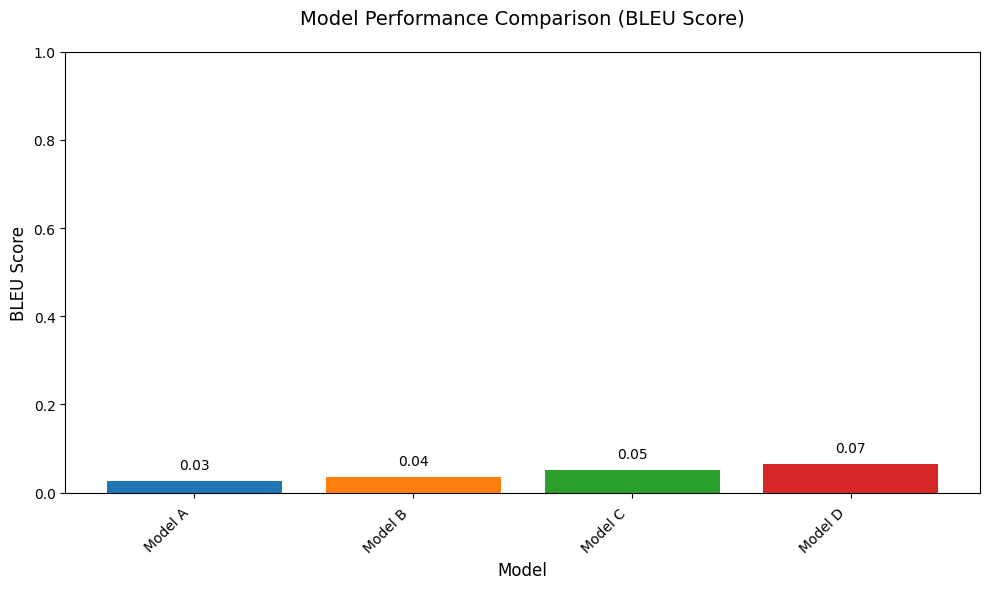

In [5]:
import matplotlib.pyplot as plt

bleu_scores = {
    'Model A ': 0.025975858641472567,
    'Model B ': 0.036279791189212894,
    'Model C ': 0.05216129425926083,
    'Model D ': 0.06574949200235158
}

# Extract model names and scores
models = list(bleu_scores.keys())
scores = list(bleu_scores.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# Customize the plot
plt.title('Model Performance Comparison (BLEU Score)', fontsize=14, pad=20)
plt.xlabel('Model', fontsize=12)
plt.ylabel('BLEU Score', fontsize=12)
plt.ylim(0, 1.0)  # BLEU ranges from 0 to 1
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f'{height:.2f}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig('bleu_scores_plot.png', dpi=300)  # Save as high-resolution image
plt.show()